# Homework 1 - Ride Duration Prediciton

## Imports

In [2]:
import math

import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Q1 - Read the data for January. How many columns are there?

In [3]:
yellow_january_2022_rides = pd.read_parquet("./data/yellow_tripdata_2022-01.parquet")
print(f'Shape of the dataset\nSamples: {yellow_january_2022_rides.shape[0]}\nColumns: {yellow_january_2022_rides.shape[1]}')

Shape of the dataset
Samples: 2463931
Columns: 19


## Q2 - What's the standard deviation of the trips duration in January?

In [4]:
# Check the data we have
yellow_january_2022_rides.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
# Create the ride duration column
yellow_january_2022_rides['ride_duration'] = yellow_january_2022_rides.tpep_dropoff_datetime - yellow_january_2022_rides.tpep_pickup_datetime
yellow_january_2022_rides['ride_duration'] = yellow_january_2022_rides['ride_duration'].apply(lambda duration: duration.total_seconds()/60)
yellow_january_2022_rides.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,ride_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333


In [6]:
# Compute the standard deviation
print(f'Standard deviation of ride duration: {yellow_january_2022_rides.ride_duration.std()}')

Standard deviation of ride duration: 46.44530513776499


## Q3 - What fraction of the records left after you dropped the outliers (< 1 minute && > 60 minutes)?

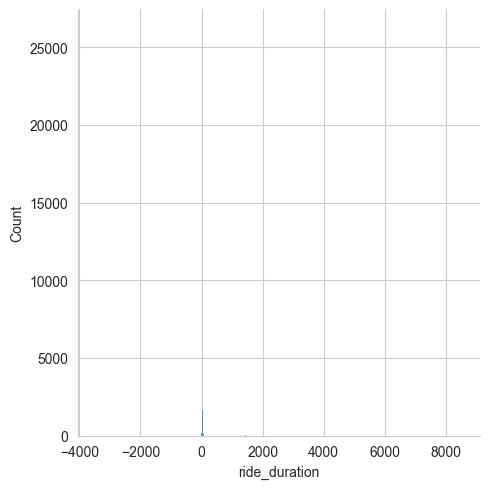

In [7]:
# Plot seaborn distribution
sns.displot(yellow_january_2022_rides.ride_duration)

In [8]:
# Drop the outliers & register the shape to assert the fraction
original_shape = yellow_january_2022_rides.shape
yellow_january_2022_rides = yellow_january_2022_rides[(yellow_january_2022_rides.ride_duration >= 1) & (yellow_january_2022_rides.ride_duration <= 60)]
outliers_free_shape = yellow_january_2022_rides.shape
print(f'Original dataset shape: {original_shape}\nOutlier free dataset shape: {outliers_free_shape}')
print(f'We kept {outliers_free_shape[0]*100/original_shape[0]}% of data')

Original dataset shape: (2463931, 20)
Outlier free dataset shape: (2421440, 20)
We kept 98.27547930522405% of data


## Q4 - What's the dimensionality of the matrix (number of columns)?

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [9]:
# Features to use
model_features = ['PULocationID', 'DOLocationID']
yellow_january_2022_rides[model_features] = yellow_january_2022_rides[model_features].astype(str)

In [10]:
# Turn dataframe into list of dicts
model_features_as_dict = yellow_january_2022_rides[model_features].to_dict(orient='records')

In [11]:
# Fit a dictionary vectorizer
dict_vectorizer = DictVectorizer()
ohe_features = dict_vectorizer.fit_transform(model_features_as_dict)

In [12]:
print(f'Feature matrix shape: {ohe_features.shape}')

Feature matrix shape: (2421440, 515)


## Q5 - What's the RMSE on train?

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data

In [13]:
# Train a linear regression model with default parameters
lr_model:LinearRegression = LinearRegression()
lr_model.fit(ohe_features, yellow_january_2022_rides.ride_duration)

LinearRegression()

In [14]:
# Evaluate model on training data
training_data_predictions = lr_model.predict(ohe_features)

In [15]:
rmse_error = math.sqrt(mean_squared_error(yellow_january_2022_rides.ride_duration, training_data_predictions))
print(f'The RMSE error for the model is {rmse_error}')

The RMSE error for the model is 6.986190814952337


## Q6 - What's the RMSE on validation?

Now let's apply this model to the validation dataset (February 2022).

In [18]:
# Apply the same processing to the validation dataset and get the features based on the previous dict vectorizer

# Calculate rides duration & remove those not belonging to the limits
yellow_february_2022_rides = pd.read_parquet("./data/yellow_tripdata_2022-02.parquet")
yellow_february_2022_rides['ride_duration'] = yellow_february_2022_rides.tpep_dropoff_datetime - yellow_february_2022_rides.tpep_pickup_datetime
yellow_february_2022_rides['ride_duration'] = yellow_february_2022_rides['ride_duration'].apply(lambda duration: duration.total_seconds()/60)
yellow_february_2022_rides = yellow_february_2022_rides[(yellow_february_2022_rides.ride_duration >= 1) & (yellow_february_2022_rides.ride_duration <= 60)]

# Get the needed columns, and use OHE
yellow_february_2022_rides[model_features] = yellow_february_2022_rides[model_features].astype(str)
yellow_february_2022_rides_features = yellow_february_2022_rides[model_features].to_dict(orient='records')
ohe_validation_features = dict_vectorizer.transform(yellow_february_2022_rides_features)

# Predict and assert RMSE
validation_predictions = lr_model.predict(ohe_validation_features)
rmse_error = math.sqrt(mean_squared_error(yellow_february_2022_rides.ride_duration, validation_predictions))
print(f'The RMSE error for the model is {rmse_error}')

The RMSE error for the model is 7.786407163179794
